In [26]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sosfiltfilt, butter, lfilter, cheby1, bessel
from scipy import interpolate
import pywt
from scipy import signal

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# load_data
sampling_rate = 100  # Hz
duration = 10
fs = 100
data = np.load('/content/drive/MyDrive/Data/simu_0.1_90_180R.npy')
data_clean = np.load('/content/drive/MyDrive/Data/simu_0_90_180R.npy')
data_clean_NoRR = np.load('/content/drive/MyDrive/Data/simu_0_90_180_NoRR.npy')


labels, signals =  data[:, -6:], data[:, :1000]
signals_clean =  data_clean[:, :1000]
signals_clean_NoRR =  data_clean_NoRR[:, :1000]

## 巴特斯通滤波器（以低通为例）

巴特沃斯低通滤波器的频率响应可以用振幅的平方对频率的公式来表示。

在连续时间域（模拟信号处理）中，巴特沃斯低通滤波器的频率响应是：

$$ H(\omega) = \frac{1}{{\sqrt{1 + (\frac{\omega}{{\omega_c}})^{2n}}}} $$

其中，$ H(\omega) $ 是滤波器在频率为 $\omega $ 处的振幅放大倍数，$\omega_c $ 是截止角频率，而 $ n $代表滤波器的阶数。

在离散时间域（数字信号处理）中，巴特沃斯低通滤波器的频率响应公式为：

$$ H(e^{j\omega}) = \frac{1}{{\sqrt{1 + (\frac{\omega}{{\omega_c}})^{2n}}}} $$

其中，$ H(e^{j\omega}) $ 表示滤波器在频率为 $ \omega $处的频率响应，而 $ \omega_c $ 是数字滤波器的截止角频率，$ n $为滤波器的阶数。

通过在不同的频率下计算振幅的平方，可以获得滤波器在不同频率下的频率响应特性。

In [10]:

def butter_bandpass(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band', analog=False, output='ba')
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data


In [20]:
# 两种butter filter写法的比较：

# butter_bandpass_0
# 当设计butter滤波器时，指定了fs则无需手动处理lowcut和highcut

# butter_bandpass_1
# 若设计butter滤波器时，未指定fs则需要手动处理lowcut和highcut，
# 输入的low和high属于[0, 1], 1表示Nyquist
def butter_bandpass_0(signal, fs, lowcut, highcut, order=4):

  # b表示前向传递系数，a表示反馈系数
  # 巴特沃斯滤波器需要3个参数：阶数、截止频率，采样频率
  # 阶数越大，滤波效果越精细，但计算复杂度也会增加
  b, a = butter(order, [lowcut, highcut], btype='band', fs=fs)


  # signal.lfilter用于对输入信号应用线性滤波器。
  # lfilter可以将一个数字滤波器的传递函数用于输入信号，以获得滤波后的输出信号
  # 线性滤波器的运算可以用差分方程表示，其中包括了滤波器的前向传递系数b，和反馈系数a
  # lfilter就是根据这些系数对输入信号进行滤波操作后输出
  filtered_signal = lfilter(b, a, signal)

  return filtered_signal


def butter_bandpass_1(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = butter(order, [low, high], btype='band', analog=False, output='ba')
    filtered_data = lfilter(b, a, data)

    return filtered_data

In [27]:

def chebyshev_bandpass(data, lowcut, highcut, fs, rp, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = cheby1(order, rp, [low, high], btype='band', analog=False, output='ba')
    filtered_data = lfilter(b, a, data)
    return filtered_data


In [28]:

def bessel_bandpass(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = bessel(order, [low, high], btype='band', analog=False, output='ba')
    filtered_data = lfilter(b, a, data)
    return filtered_data

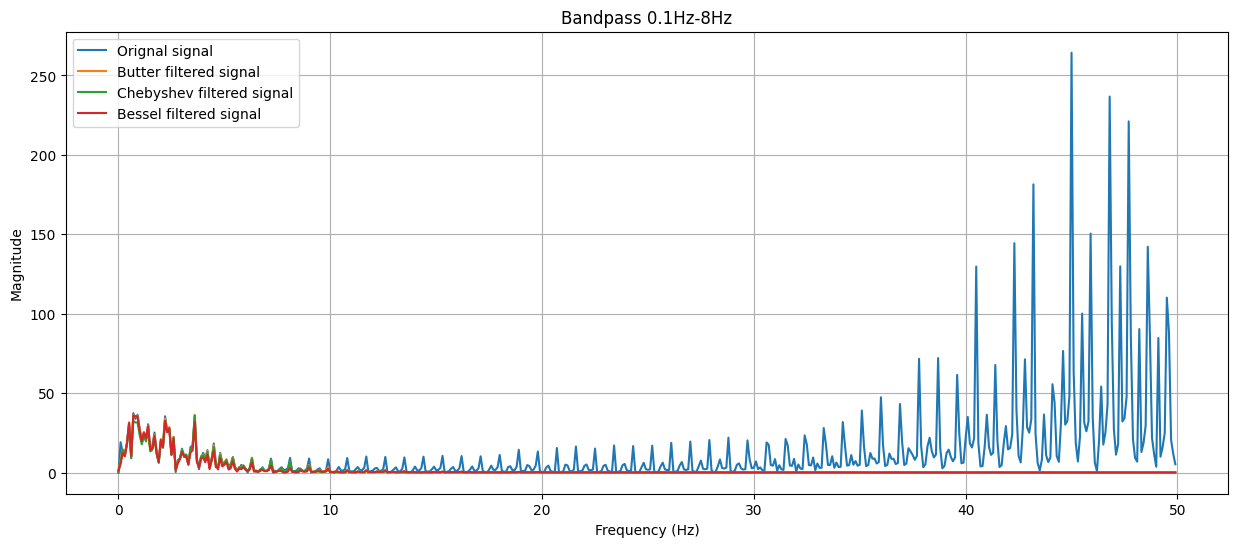

In [33]:
def standize(data):
    return (data - np.mean(data))/np.std(data)

N = 1000
for cnt, o_signal in enumerate(signals):

  signal_butter = butter_bandpass_0(standize(o_signal), 100, 0.1, 8)
  signal_chebyshev = chebyshev_bandpass(standize(o_signal), 0.1, 8, 100, 1)
  signal_bessel = bessel_bandpass(standize(o_signal), 0.1, 8, 100)

  freqs = np.fft.fftfreq(N, 1/fs)  # 获取频率轴
  positive_freqs = freqs[:N//2]

  fft_result_o = np.fft.fft(standize(o_signal))
  magnitude_o = np.abs(fft_result_o)[:N//2]

  # 进行FFT

  fft_result_butter = np.fft.fft(signal_butter)
  magnitude_butter = np.abs(fft_result_butter)[:N//2]

  fft_result_chebyshev = np.fft.fft(signal_chebyshev)
  magnitude_chebyshev = np.abs(fft_result_chebyshev)[:N//2]

  fft_result_bessel = np.fft.fft(signal_bessel)
  magnitude_bessel = np.abs(fft_result_bessel)[:N//2]


  plt.figure(figsize=(15, 6))

  plt.plot(positive_freqs, magnitude_o, label='Orignal signal')
  plt.plot(positive_freqs, magnitude_butter, label='Butter filtered signal')
  plt.plot(positive_freqs, magnitude_chebyshev, label='Chebyshev filtered signal')
  plt.plot(positive_freqs, magnitude_bessel, label='Bessel filtered signal')

  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Magnitude')
  plt.title('Bandpass 0.1Hz-8Hz')
  plt.grid()
  plt.legend()
  break